# Import Required Libraries
Import the necessary libraries, including normflows, pandas, and scikit-learn.

In [1]:
# Import Required Libraries
# ML
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt

# Data
import pandas as pd

# Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
# Custom
from helpers_data import *
from helpers_model import *

In [3]:
latest_save = "./lightning_logs/version_21/checkpoints/epoch=65-step=12342.ckpt"

# Load Dataset
Load the precomputed dataset using pandas.

In [4]:
mode = "load" # "load" or `"generate" `
if mode == "load":
    data_stimulated = load_model_data()
else:
    # see steps below in markdown
    data = load_data() # brfss data load
    data = drop_unwanted(data) # drop unwanted columns
    pop_data = load_data(data_set="census") # load census data
    stratified_data = get_stratified_data(data) # get stratified data
    data_stimulated = generate_stimulated_base(data, pop_data) # generate stimulated data BASE
    data_stimulated = stimulate_data(data_stimulated, stratified_data, mode="both") # stimulate data
    data_stimulated = encode_data(data_stimulated) # encode data (categorical values)
    save_data(data_stimulated) # save dataset

# Preprocess Data
Preprocess the data, including splitting into features and labels, and standardizing the features.

In [5]:
X_train, X_test, y_train, y_test = randomized_train_test(data_stimulated)
X_train, X_val, y_train, y_val = randomized_train_test(pd.concat([X_train, y_train], axis=1))

# Define Normalizing Flow Model
Define the architecture of the normalizing flow model using normflows.

In [6]:
# Class: helpers_model.NormalizingFlowModel

# Train Normalizing Flow Model
Train the normalizing flow model on the preprocessed dataset.

In [7]:
batch_size = 2 ** 13

In [8]:
# Convert training data to torch tensors
X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    drop_last=True, 
    num_workers=10,
    pin_memory=True,
    persistent_workers=True)

In [9]:
# Initialize Trainer
X_val_tensor = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    drop_last=True, 
    num_workers=10,
    pin_memory=True,
    persistent_workers=True)

In [10]:
# Initialize model
input_dim = X_train.shape[1]
model = NormalizingFlowModel(input_dim, do_logging=True)

In [11]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    verbose = True,
    filename = None,
    monitor = 'val_loss',
    mode = 'min',
)

In [12]:
# Initialize Trainer
trainer = pl.Trainer(
    max_epochs=70,
    log_every_n_steps=2,
    callbacks = [checkpoint_callback]
    )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/saad/Documents/School/Research/Alzheimer_2024/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [13]:
# Train the model
train = False
if train:
    trainer.fit(model, train_loader, val_loader, ckpt_path=latest_save)
else:
    model = NormalizingFlowModel.load_from_checkpoint(latest_save)

# Generate Samples from Trained Model
Generate samples from the trained normalizing flow model to capture the underlying distribution.

In [14]:
# Generate samples from the trained model
num_samples = 1000
_1, _2 = model.model.sample(num_samples)

In [15]:
_1 = _1.detach().cpu().numpy()
_2 = _2.detach().cpu().unsqueeze(1).numpy()

In [16]:
_1.shape, _2.shape

((1000, 69), (1000, 1))

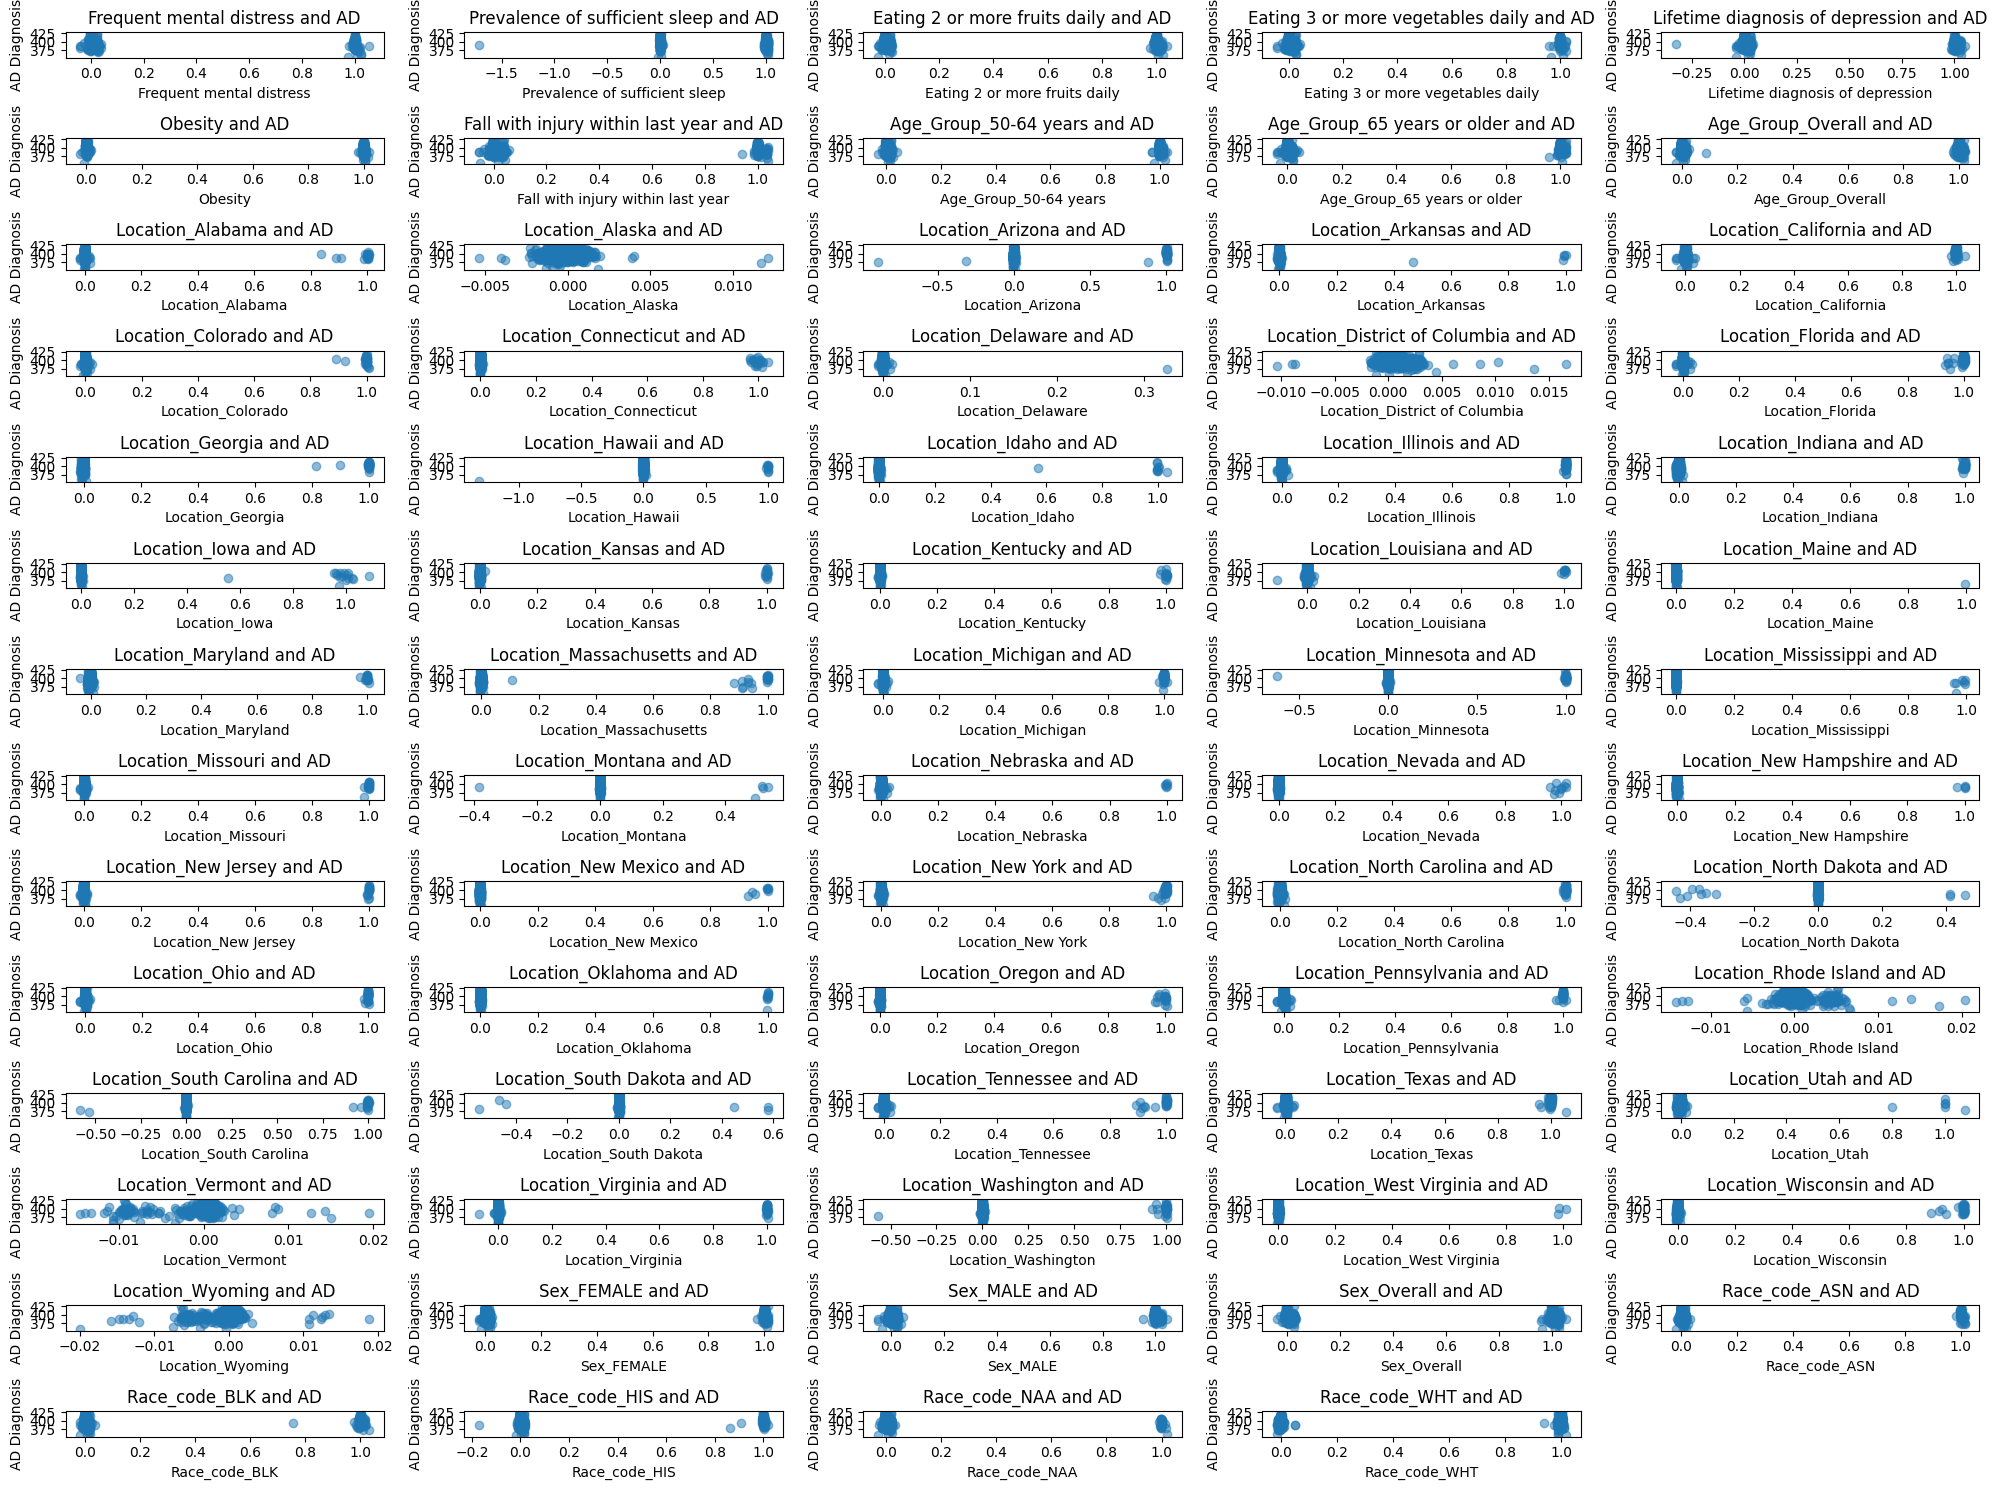

In [17]:
feature_names = data_stimulated.drop(columns=['HAS_ALZHEIMERS', "Oral health:  tooth retention"]).columns
num_features = len(feature_names)
num_cols = 5
num_rows = (num_features + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
axes = axes.flatten()

for i in range(num_features):
    axes[i].scatter(_1[:, i], _2, alpha=0.5)
    axes[i].set_title(f'{feature_names[i]} and AD')
    axes[i].set_xlabel(f'{feature_names[i]}')
    axes[i].set_ylabel('AD Diagnosis')

# Hide any unused subplots
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Class Prediction Using Generated Samples
Use the generated samples to perform class prediction.

# Evaluate Model Performance
Evaluate the performance of the model using metrics such as accuracy, precision, recall, and F1 score.

In [18]:
# Evaluate the model
model.eval()
model.freeze()
model.cpu()

NormalizingFlowModel(
  (base): DiagGaussian()
  (model): NormalizingFlow(
    (q0): DiagGaussian()
    (flows): ModuleList(
      (0): AutoregressiveRationalQuadraticSpline(
        (mprqat): MaskedPiecewiseRationalQuadraticAutoregressive(
          (autoregressive_net): MADE(
            (preprocessing): Identity()
            (initial_layer): MaskedLinear(in_features=69, out_features=128, bias=True)
            (blocks): ModuleList(
              (0-1): 2 x MaskedResidualBlock(
                (linear_layers): ModuleList(
                  (0-1): 2 x MaskedLinear(in_features=128, out_features=128, bias=True)
                )
                (activation): ReLU()
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (final_layer): MaskedLinear(in_features=128, out_features=1587, bias=True)
          )
        )
      )
      (1): LULinearPermute(
        (permutation): _RandomPermutation()
        (linear): _LULinear()
      )
      (2): A

In [19]:
with torch.no_grad():
    # Convert test data to torch tensor
    X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    
    # Get log probabilities for test data
    log_probs = model(X_test_tensor)
    
    # Convert log probabilities to class predictions (assuming binary classification)
    print(log_probs, log_probs.mean(), log_probs.min(), log_probs.max())
    y_pred = (log_probs > log_probs.median()).float().numpy()
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')

tensor([414.6601, 379.6885, 418.1978,  ..., 394.6096, 423.6002, 416.7610]) tensor(413.8595) tensor(315.0839) tensor(430.5884)
Accuracy: 0.5207
F1 Score: 0.5294
Precision: 0.5391
Recall: 0.5200


In [ ]:
feature_names = data_stimulated.drop(columns=['HAS_ALZHEIMERS', "Oral health:  tooth retention"]).columns
num_features = len(feature_names)
num_cols = 5
num_rows = (num_features + num_cols - 1) // num_cols

with torch.no_grad():
    # Convert test data to torch tensor
    X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    
    # Get log probabilities for test data
    log_probs = model(X_test_tensor)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))
    axes = axes.flatten()

    for i in range(num_features):
        axes[i].scatter(X_test_tensor[:, i], log_probs, alpha=0.5, c=(log_probs > log_probs.median()).float().numpy())
        axes[i].set_title(f'{feature_names[i]} and AD')
        axes[i].set_xlabel(f'{feature_names[i]}')
        axes[i].set_ylabel('AD Diagnosis')

# Hide any unused subplots
for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()